## Most of the features are not normally distributed to start with.
StandardScaler and MinMaxScaler are more common when dealing with continuous numerical data.

- MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge (e.g. pixel intensities that go from 0 to 255 in the RGB color range).

- StandardScaler is useful for the features that follow a Normal distribution. This is clearly illustrated in the image below (source).

- My features have distributions that are heavily skewed to the right -> Use MinMaxScaler
- Source: https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler

In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz

In [61]:
df = pd.read_csv('marketing_data.csv')
#Preprocess Income
df['Income']=df[' Income ']
df['Income']=df.Income.str.replace('$','')
df['Income']=df.Income.str.replace(',','')#.astype("Int64")
df['Income']=df.Income.astype("float")
df['Income'].fillna((df['Income'].median()), inplace=True)
df = df.drop([' Income '], axis=1)
df.drop(df.index[[527,513,827,2233]],inplace=True) #drop income outlier 527 and age outliers
df['LogIncome'] = np.log1p(df['Income'])

#Preprocess Education
df.loc[df['Education']=='2n Cycle','Education']='Master'
df.loc[df['Education']=='Graduation','Education']='Bachelor'

#Preprocess Children
df['NumChildren']  = df['Kidhome']+df['Teenhome']
df['HasChildren']=np.where(df.NumChildren> 0, 1, 0)

#Preprocess Marital Status
df['Solitary']=np.where(((df.Marital_Status== 'Married')|(df.Marital_Status== 'Together')), 0, 1)

#Preprocess Date and Make Age
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
df['age'] = 2014 - df['Year_Birth']

#Make total spending, num promotions, and num orders accepted columns
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] +\
        +df['MntSweetProducts'] + df['MntGoldProds']
df['AcceptedCmpTot']=df['AcceptedCmp1']+ df['AcceptedCmp2']+ df['AcceptedCmp3']+ df['AcceptedCmp4']+\
       + df['AcceptedCmp5']
df['NumTotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases']+df['NumCatalogPurchases']+\
    df['NumStorePurchases']+df['NumWebVisitsMonth']

# Make a column for spending normalized by length customer -> Consider doing this for other amounts as well
latest_date=(df["Dt_Customer"] + pd.to_timedelta(df['Recency'],'d')).max()
df['Len_Customer']=latest_date - df["Dt_Customer"]
df['Len_Customer']=df['Len_Customer'] / pd.to_timedelta(1, unit='D') #Convert to float
df['MntSpentNorm']=df['MntTotal']/df['Len_Customer']

In [62]:
df[df.age>100]

,ID,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm


In [63]:
df[df.Income>300000]

,ID,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm


In [64]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm'],
      dtype='object')

# Description of Customer Characteristics and Findings (Post)
- Cluster 0:Highish median income (.5 std to the right)
- Cluster 1: High median income (1 std to the right). Average age (about45). Likely to have no children. 
- Cluster 2: Lower than average median income (1 std to the left). Youngest cluster (median age of about 40 vs. 45 for all)
- Cluster 3: Lower than average median income (.5 std to the left)
- Cluster 4: Lower than average median income (.5 std to the left)
- Cluster 5: High median income (1 std to the right). Average age (about 45). Likely to have no children. (The Strivers)

- Cluster 5 is higher educated than Cluster 1 (more PhD's and everyone in Cluster 5 has graduated from college)


## Spending
- While Cluster 1 has spent the most overall, Cluster 2 spends almost twice as much when normalized by length as a customer. Cluster 0 are the third biggest spenders.

- Clusters 0, 1, 2 have been customers for about twice as long as Clusters 3, 4, 5 (600 vs 300)
- Clusters 0 and 2 spend the most on wines overall, but Cluster 5 spends the most when normalized. 
- For other categories, Cluster 1 spends the most overall followed by Clusters 5 and 0 spending. When normalized, Cluster 5 spends the most in every category.  

## Web, catalog
- Cluster 0 customers accept the most deals,followed by Cluster 2-4 customers.  Clusters 1 and 5 are not into deals.
- Cluster 0 is the most active on the web overall, followed by Clusters 1 and 5. When normalized, Cluster 5 are the most active on the web.
- Cluster 5 are the most active catalog users overall, followed by Clusters 1 and 5. When normalized, Cluster 5 are the most active catalog users.
- Both general and aggregated, Cluster 5 customers shop the most in store, followed by Clusters 0 and 1.
- Clusters 2-4 are the most active web users.  

- Overall, promotions did not get a high response rate and noone has accepted all 5 campaigns.
- Date information on campaigns is not available, but based on logical analysis using customer join dates, it appears that campaigns were ongoing.
- Cluster 5 were particularly prone to accept campaigns 1 and 5, followed by Cluster 1 customers.
- Campaign 2 had a very low acceptance rate.
- Clusters 2 and 3 accepted campaign 3 at a higher rate than other customers.
- Cluster 0 customers accepted campaign 4 at a higher rate than other customers.
- Clusters 3 accepted campaign 5 at a higher rate than other customers.


In [65]:
cats = {'Education', 'Marital_Status', 
       'Kidhome', 'Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain','Country','HasChildren','Solitary',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes


nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer','LogIncome','MntSpentNorm','MntTotal', 'AcceptedCmpTot','NumTotalPurchases','Year_Birth'} #drop some highly correlated transformed vars

#X = df.drop(list(nums),axis=1) #Dropping Dt_Customer since this is causing problems in RF
X = df[list(nums)] #Dropping Dt_Customer since this is causing problems in RF

In [66]:
pd.set_option('display.max_columns', 500)

In [67]:
X.head()

,MntWines,Recency,Len_Customer,NumWebPurchases,age,MntSweetProducts,NumChildren,NumWebVisitsMonth,MntGoldProds,MntMeatProducts,NumDealsPurchases,MntFishProducts,MntFruits,NumStorePurchases,Income,NumCatalogPurchases
0,189,0,110.0,4,44,189,0,1,218,379,1,111,104,6,84835.0,4
1,464,0,111.0,7,53,0,0,5,37,64,1,7,5,7,57091.0,3
2,134,0,144.0,3,56,2,1,2,30,59,1,15,11,5,67267.0,2
3,10,0,146.0,1,47,0,2,7,0,1,1,0,0,2,32474.0,0
4,6,0,179.0,3,25,0,1,7,34,24,2,11,16,2,21474.0,1


In [68]:
np.shape(X)

(2236, 16)

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

# IF DO PCA, UNCOMMENT THE CELL BELOW

In [70]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 0.95)
# pca.fit(data_rescaled)
# reduced = pca.transform(data_rescaled)
# print(np.shape(reduced))
# num_components = np.shape(reduced)[1]
# print(num_components)
# columns = ['col'+str(i) for i in range(1,num_components)]
# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(reduced)

# IF DO PCA, COMMENT OUT THE CELL BELOW

In [71]:
num_components=np.shape(X)[1]

Elbow Method:


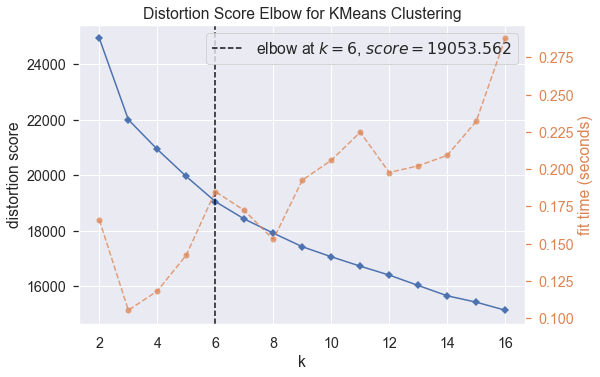

In [72]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method:')
Elbow_M = KElbowVisualizer(KMeans(), k=num_components, random_seed=42) #for the 20 numeric
Elbow_M.fit(data_rescaled) 
Elbow_M.show();

In [73]:
clusterer=KMeans(n_clusters=n_clusters, random_state=42)

from sklearn.metrics import silhouette_score

def get_silhouette_score(clusterer, X):
    clusterer.fit(X)
    label = clusterer.predict(X)
    #print(f'Silhouette Score: {silhouette_score(X, label)}')
    return silhouette_score(X, label)

range_n_clusters = [2, 3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    clusterer=KMeans(n_clusters=n_clusters, random_state=42)
    print(f"Silhouette score for {n_clusters} clusters: {get_silhouette_score(clusterer, data_rescaled)}")

Silhouette score for 2 clusters: 0.30658279135953864
Silhouette score for 3 clusters: 0.2173031697961535
Silhouette score for 4 clusters: 0.17930969233849967
Silhouette score for 5 clusters: 0.11482482717648303
Silhouette score for 6 clusters: 0.11490024549914647
Silhouette score for 7 clusters: 0.11066179272927144
Silhouette score for 8 clusters: 0.1161563783639185


In [13]:
n_clusters=6

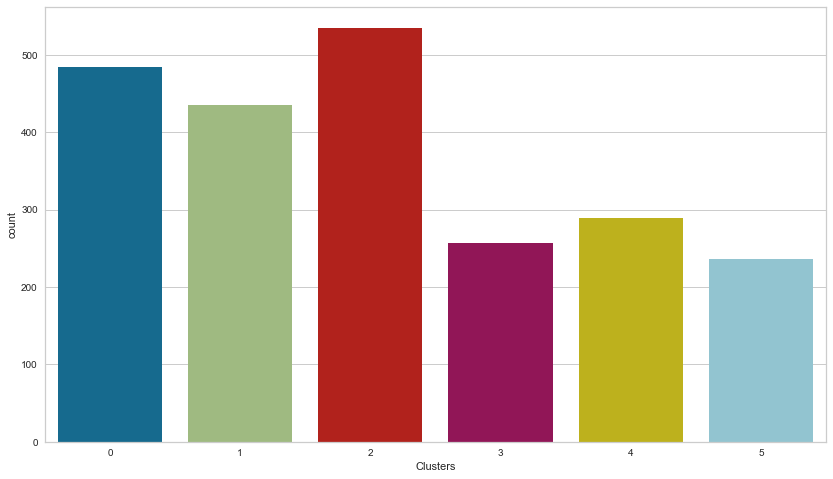

In [14]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Clusters'] = kmeans.fit_predict(data_rescaled)

plt.figure(figsize=(14, 8))
sns.countplot(x='Clusters', data=df)
plt.show()

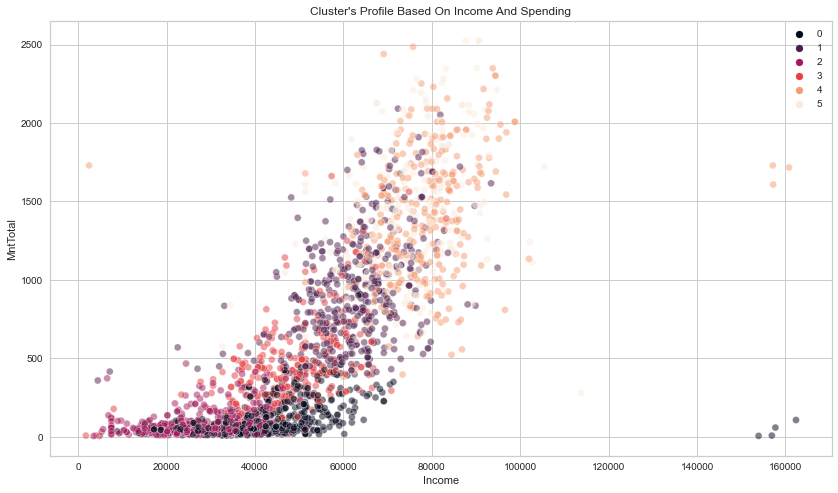

In [15]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntTotal"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

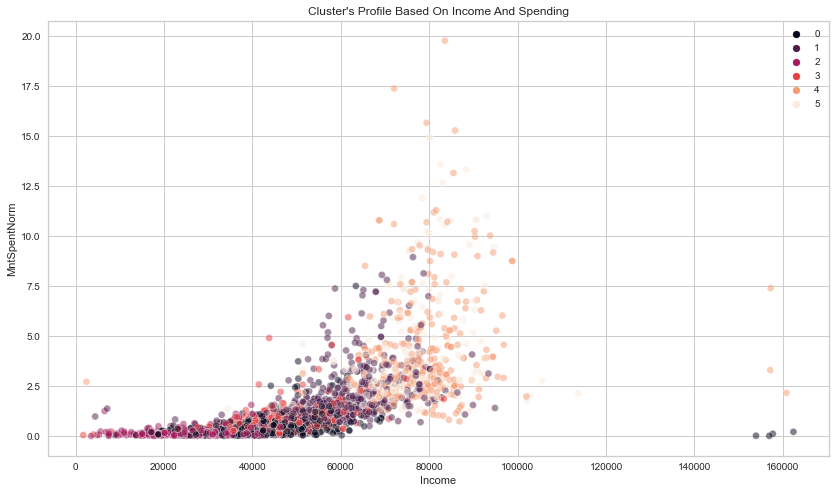

In [16]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [17]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters'],
      dtype='object')

In [18]:
# x =df["LogIncome"]
# y =df["AcceptedCmpTot"]
# z =df["MntSpentNorm"]
# #To plot
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(x,y,z, c="maroon", marker="o" )
# ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
# plt.show()

In [19]:
# x =df["LogIncome"]
# y =df["AcceptedCmpTot"]
# z =df["MntSpentNorm"]
# fig = plt.figure(figsize=(10,8))
# ax = plt.subplot(111, projection='3d', label="bla")
# ax.scatter(x, y, z, s=40, c=df["Clusters"], marker='o', cmap = 'PuRd' )
# ax.set_title("The Plot Of The Clusters")
# plt.show()

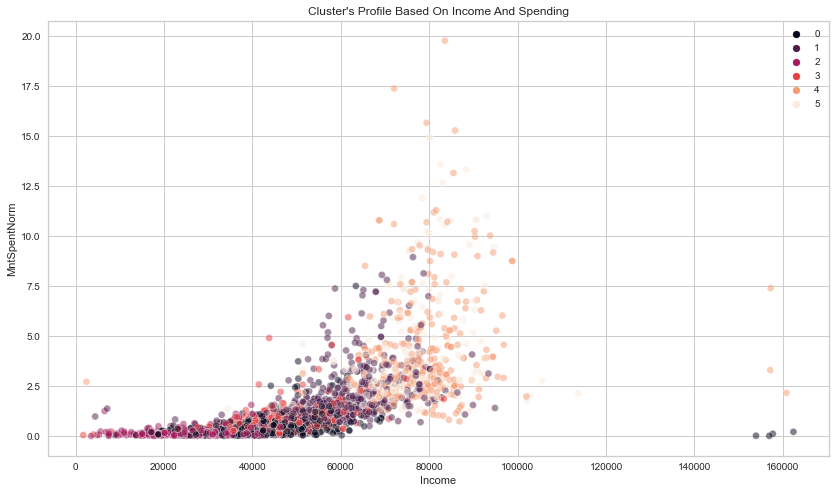

In [20]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [21]:
df["Clusters"].value_counts()

2    535
0    484
1    435
4    289
3    257
5    236
Name: Clusters, dtype: int64

<AxesSubplot:>

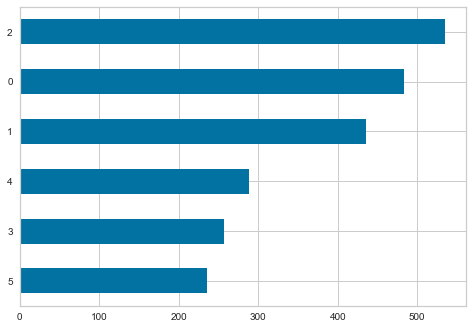

In [22]:
df.Clusters.value_counts().sort_values().plot(kind = 'barh')

In [23]:
groupsKmeans=df.groupby(['Clusters'])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

In [24]:
groupsKmeans.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

ID                                                Year_Birth  \
         count      sum  min    max         mean          std      count   
Clusters                                                                   
0          484  2673842   13  11188  5524.466942  3260.755208        484   
1          435  2439215    1  11176  5607.390805  3302.502813        435   
2          535  3053980   22  11191  5708.373832  3225.390214        535   
3          257  1355603    9  11171  5274.719844  3312.778611        257   
4          289  1630185    0  11088  5640.778547  3187.396391        289   
5          236  1344198  175  11112  5695.754237  3151.381506        236   

                                                      Kidhome               \
              sum   min   max         mean        std   count  sum min max   
Clusters                                                                     
0          950949  1940  1989  1964.770661   9.637266     484  349   0   2   
1          854549  1943  1992  1964.480460  10.540091     435   45   0   2   
2         1057767  1947  1996  1977.134579   8.959157     535  403   0   2   
3          505466  1946  1991  1966.793774   9.823853     257  183   0   2   
4          568720  1941  1995  1967.889273  13.693883     289    4   0   1   
5          465005  1943  1993  1970.360169  12.463800     236    9   0   1   

                             Teenhome                                   \
              mean       std    count  sum min max      mean       std   
Clusters                                                                 
0         0.721074  0.570759      484  376   0   2  0.776860  0.494066   
1         0.103448  0.319651      435  351   0   2  0.806897  0.474656   
2         0.753271  0.452690      535   91   0   2  0.170093  0.385897   
3         0.712062  0.540156      257  237   0   2  0.922179  0.452612   
4         0.013841  0.117033      289   16   0   1  0.055363  0.229085   
5         0.038136  0.191931      236   62   0   2  0.262712  0.450588   

         Recency                                      MntWines              \
           count    sum min max       mean        std    count     sum min   
Clusters                                                                     
0            484  25848   0  99  53.404959  29.045500      484   30214   0   
1            435  21171   0  99  48.668966  28.537805      435  247710   7   
2            535  24599   0  99  45.979439  28.747538      535   14783   0   
3            257  12014   0  98  46.747082  27.912990      257   74927   1   
4            289  14817   0  99  51.269896  29.658177      289  186247   1   
5            236  11375   0  99  48.199153  29.307006      236  126148   5   

                                       MntFruits                              \
           max        mean         std     count    sum min  max        mean   
Clusters                                                                       
0          734   62.425620   74.288820       484   2214   0   58    4.574380   
1         1486  569.448276  313.695160       435  13529   0  142   31.101149   
2          308   27.631776   41.866885       535   3094   0   65    5.783178   
3         1099  291.544747  200.082109       257   2892   0   90   11.252918   
4         1493  644.453287  342.897172       289  11513   0  169   39.837370   
5         1259  534.525424  268.593110       236  25511   0  199  108.097458   

                    MntMeatProducts                                            \
                std           count     sum min   max        mean         std   
Clusters                                                                        
0          7.615273             484   11769   1   153   24.316116   24.906560   
1         30.743908             435   74930  12   653  172.252874  104.266852   
2          8.263322             535   11568   0   217   21.622430   24.223512   
3         15.657536             257   23549   1

In [25]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,5589.008497,1968.898032,0.444097,0.506708,49.116279,304.12746,26.275939,166.983453,37.536225,27.080501,43.983005,2.326029,4.087657,2.663238,5.795617,5.318873,0.072898,0.074687,0.072451,0.064401,0.013417,0.149374,0.008945,51952.614043,10.753375,0.950805,0.715116,0.355098,45.101968,605.986583,0.297853,20.191413,450.773256,1.653348,2.062612
std,3244.826887,11.703281,0.538459,0.544609,28.957284,336.59181,39.724007,225.689645,54.648562,41.299504,52.061568,1.933032,2.779988,2.923898,3.251129,2.426886,0.260027,0.262944,0.259291,0.245520,0.115077,0.356536,0.094173,21411.466851,0.500319,0.752204,0.451460,0.478650,11.703281,601.865156,0.678737,7.291811,202.181561,2.173188,1.624647
min,0.000000,1940.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2828.250000,1959.000000,0.000000,0.000000,24.000000,24.00000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35502.500000,10.477386,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.750000,0.202060,1.000000
50%,5454.500000,1970.000000,0.000000,0.000000,49.000000,174.00000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,0.000000,44.000000,396.500000,0.000000,19.000000,453.000000,0.866443,2.000000
75%,8421.750000,1977.000000,1.000000,1.000000,74.000000,504.25000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68275.750000,11.131325,1.000000,1.000000,1.000000,55.000000,1045.500000,0.000000,25.000000,626.000000,2.270000,3.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.00000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,74.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,5.000000


[56153.0, 396440.0, 45830.0, 121991.0, 403147.0, 331425.0]
['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']


<AxesSubplot:>

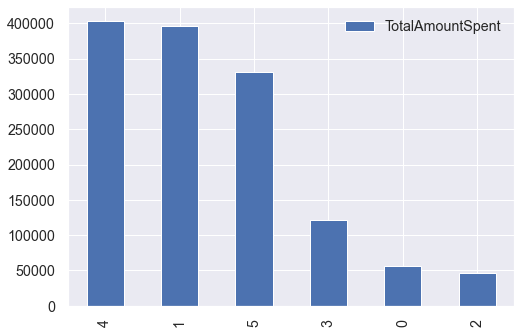

In [44]:
cluster_mnt_totals = [[]]*n_clusters

for i in range(n_clusters):
    cluster_i=df[df["Clusters"]==i]
    cluster_mnt_totals[i] = cluster_i.MntTotal.mean()*len(cluster_i)

print(cluster_mnt_totals) 

columns = ['cluster'+str(i) for i in range(n_clusters)]
print(columns)

df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:'TotalAmountSpent'},axis=1)

df_cluster_mnt_totals.sort_values('TotalAmountSpent', ascending=False).plot.bar()

[233.08095941438535, 959.7581064012005, 101.22818056173077, 248.38991225305082, 1213.9934410244598, 940.4353842193123]
['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']


<AxesSubplot:>

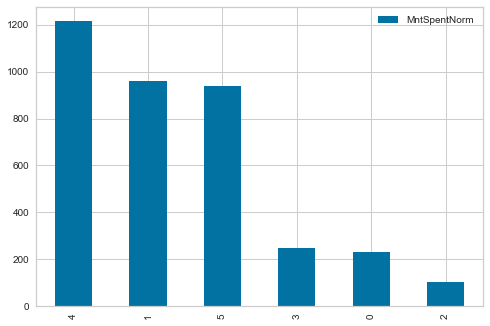

In [27]:
cluster_mnt_totals = [[]]*n_clusters

for i in range(n_clusters):
    cluster_i=df[df["Clusters"]==i]
    cluster_mnt_totals[i] = cluster_i.MntSpentNorm.mean()*len(cluster_i)

print(cluster_mnt_totals) 

columns = ['cluster'+str(i) for i in range(n_clusters)]
print(columns)

df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:'MntSpentNorm'},axis=1)

df_cluster_mnt_totals.sort_values('MntSpentNorm', ascending=False).plot.bar()

<!-- # Description of Customer Behavior
- Clusters 2 and 4 are big clusters that spend little
- Clusters 2 and 4  are usually educated, relatively recent customers, but are much more likely to have children than Clusters 1 and 3. Perhaps this store focuses on high-end more expensive products (Whole Foods at Monterey?) and people with children are finding it harder to afford shopping there, on average.  Cluster 5 customers have about just as likely to have children as Clusters 2 and 4, yet have a higher income.  
- To confirm these findings, Clusters 2, 4, and 5 are making the most deal purchases, especially when these are normalized by length someone spend as a customer.
 -->

In [28]:
#palette=sns.color_palette("rocket")
palette=sns.color_palette("Set2")

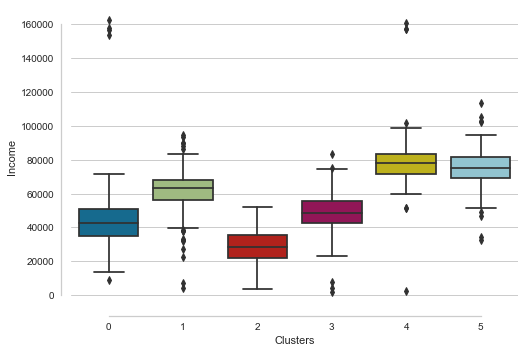

In [29]:
sns.boxplot(x="Clusters", y="Income",
            data=df)
sns.despine(offset=10, trim=True)

### Clusters 1 and 3 are the high income clusters

In [30]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,5589.008497,1968.898032,0.444097,0.506708,49.116279,304.12746,26.275939,166.983453,37.536225,27.080501,43.983005,2.326029,4.087657,2.663238,5.795617,5.318873,0.072898,0.074687,0.072451,0.064401,0.013417,0.149374,0.008945,51952.614043,10.753375,0.950805,0.715116,0.355098,45.101968,605.986583,0.297853,20.191413,450.773256,1.653348,2.062612
std,3244.826887,11.703281,0.538459,0.544609,28.957284,336.59181,39.724007,225.689645,54.648562,41.299504,52.061568,1.933032,2.779988,2.923898,3.251129,2.426886,0.260027,0.262944,0.259291,0.245520,0.115077,0.356536,0.094173,21411.466851,0.500319,0.752204,0.451460,0.478650,11.703281,601.865156,0.678737,7.291811,202.181561,2.173188,1.624647
min,0.000000,1940.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2828.250000,1959.000000,0.000000,0.000000,24.000000,24.00000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35502.500000,10.477386,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.750000,0.202060,1.000000
50%,5454.500000,1970.000000,0.000000,0.000000,49.000000,174.00000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,0.000000,44.000000,396.500000,0.000000,19.000000,453.000000,0.866443,2.000000
75%,8421.750000,1977.000000,1.000000,1.000000,74.000000,504.25000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68275.750000,11.131325,1.000000,1.000000,1.000000,55.000000,1045.500000,0.000000,25.000000,626.000000,2.270000,3.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.00000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,74.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,5.000000


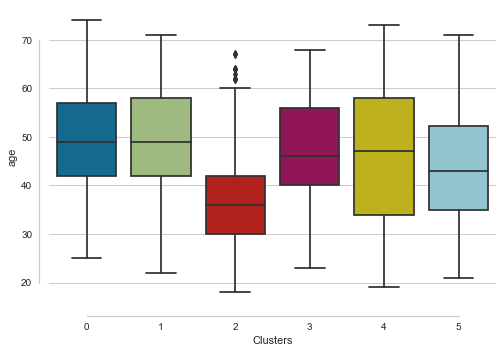

In [31]:
sns.boxplot(x="Clusters", y="age",
            data=df)
sns.despine(offset=10, trim=True)

### Age is similar across clusters, with median age in the 40s

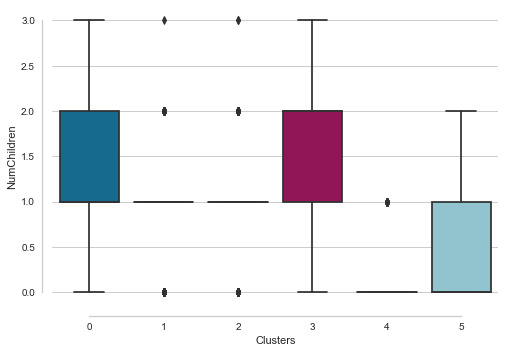

In [32]:
sns.boxplot(x="Clusters", y="NumChildren",
            data=df)
sns.despine(offset=10, trim=True)

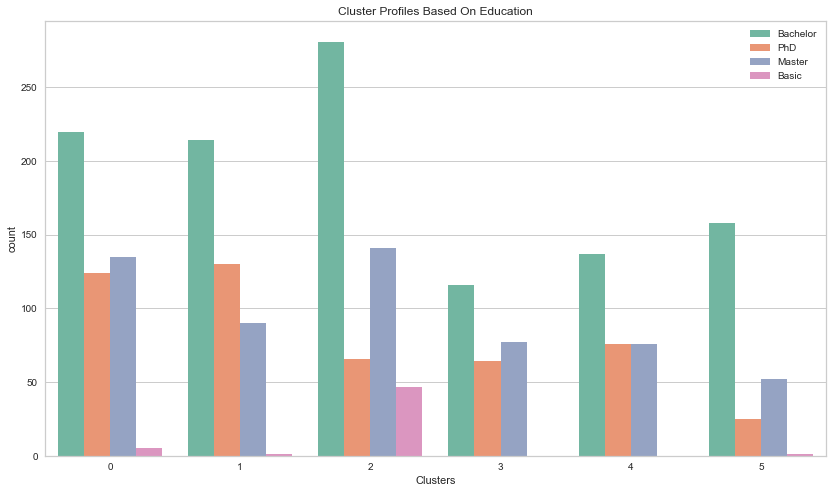

In [33]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["Education"], palette = palette)

plot.set_title("Cluster Profiles Based On Education")
plt.legend()
plt.show()

In [34]:
# plt.figure(figsize=(14,8))

# x,y = 'Clusters', 'Education'

# df1 = df.groupby(x)[y].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('Percent').reset_index()

# g = sns.catplot(x=x,y='Percent',hue=y,kind='bar',data=df1,palette=palette)
# g.ax.set_ylim(0,60)

# for p in g.ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     g.ax.text(txt_x,txt_y,txt)
#     #plt.figure(figsize=(14,8))
#     #plt.figure(figsize=(14,8))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


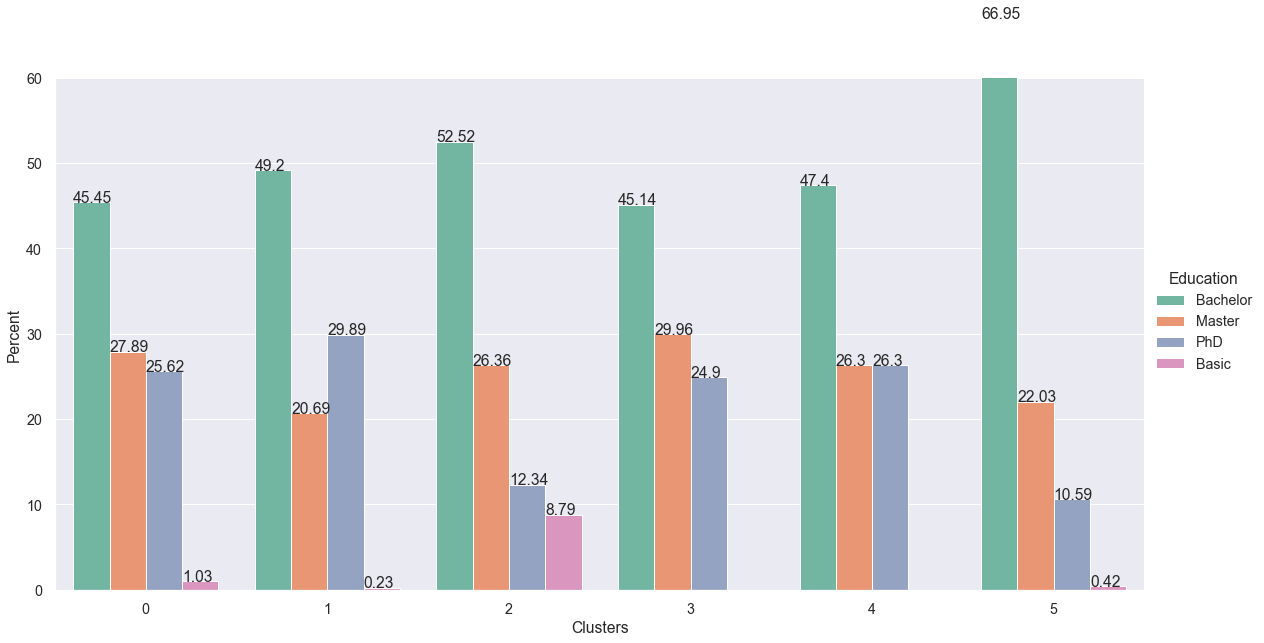

In [35]:
#plt.figure(figsize=(14,8)) #does not work, use height and aspect
sns.set(font_scale = 1.3)

x,y = 'Clusters', 'Education'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()

g = sns.catplot(x=x,y='Percent',hue=y,kind='bar',data=df1,palette=palette,height=8,aspect=2)
#g.figure(figsize=(14,8))

g.ax.set_ylim(0,60)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) #+ '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    #plt.figure(figsize=(14,8))
    #plt.figure(figsize=(14,8))

In [36]:
groupsKmeansEdu=df.groupby(['Clusters','Education']).agg(['count'])

In [37]:
groupsKmeansEdu

ID Year_Birth Marital_Status Kidhome Teenhome  \
                   count      count          count   count    count   
Clusters Education                                                    
0        Bachelor    220        220            220     220      220   
         Basic         5          5              5       5        5   
         Master      135        135            135     135      135   
         PhD         124        124            124     124      124   
1        Bachelor    214        214            214     214      214   
         Basic         1          1              1       1        1   
         Master       90         90             90      90       90   
         PhD         130        130            130     130      130   
2        Bachelor    281        281            281     281      281   
         Basic        47         47             47      47       47   
         Master      141        141            141     141      141   
         PhD          66         66             66      66       66   
3        Bachelor    116        116            116     116      116   
         Master       77         77             77      77       77   
         PhD          64         64             64      64       64   
4        Bachelor    137        137            137     137      137   
         Master       76         76             76      76       76   
         PhD          76         76             76      76       76   
5        Bachelor    158        158            158     158      158   
         Basic         1          1              1       1        1   
         Master       52         52             52      52       52   
         PhD          25         25             25      25       25   

                   Dt_Customer Recency MntWines MntFruits MntMeatProducts  \
                         count   count    count     count           count   
Clusters Education                                                          
0        Bachelor          220     220      220       220             220   
         Basic               5       5        5         5               5   
         Master            135     135      135       135             135   
         PhD               124     124      124       124             124   
1        Bachelor          214     214      214       214             214   
         Basic               1       1        1         1               1   
         Master             90      90       90        90              90   
         PhD               130     130      130       130             130   
2        Bachelor          281     281      281       281             281   
         Basic              47      47       47        47              47   
         Master            141     141      141       141             141   
         PhD                66      66       66        66              66   
3        Bachelor          116     116      116       116             116   
         Master             77      77       77        77              77   
         PhD                64      64       64        64              64   
4        Bachelor          137     137      137       137             137   
         Master             76      76       76        76              76   
         PhD                76      76       76        76              76   
5        Bachelor          158     158      158       158             158   
         Basic               1       1        1         1               1   
         Master             52      52       52        52              52   
         PhD                25      25       25        25              25   

                   MntFishProducts MntSweetProducts MntGoldProds  \
                             count            count        count   
Clusters Education                                                 
0        Bachelor              220              220          220   
         Basic                   5              

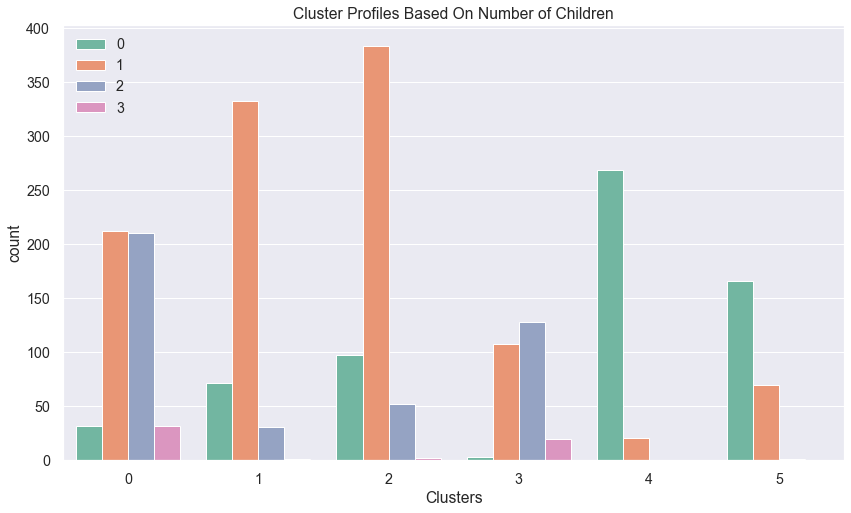

In [38]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["NumChildren"], palette = palette)

plot.set_title("Cluster Profiles Based On Number of Children")
plt.legend()
plt.show()

In [39]:
### Most customers in Clusters 1 and 3 don't have children, but Cluster 1 customers are likelier to have at least one child

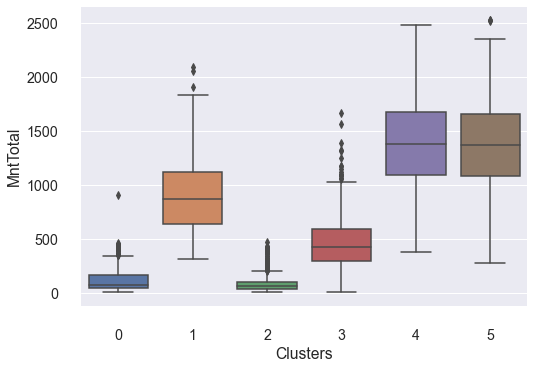

In [40]:
sns.boxplot(x="Clusters", y="MntTotal",
            data=df)
sns.despine(offset=10, trim=True)

In [41]:
### Cluster 3 customers have the highest median overall spending, followed by Cluster 1 and 5 customers

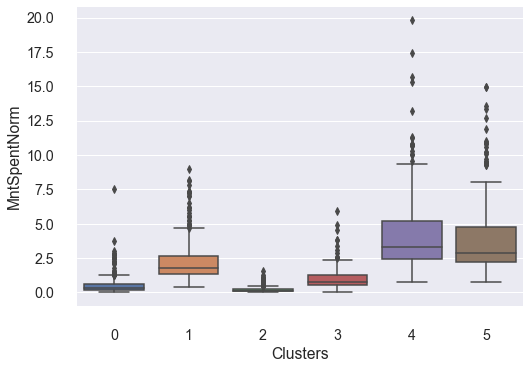

In [42]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            #hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

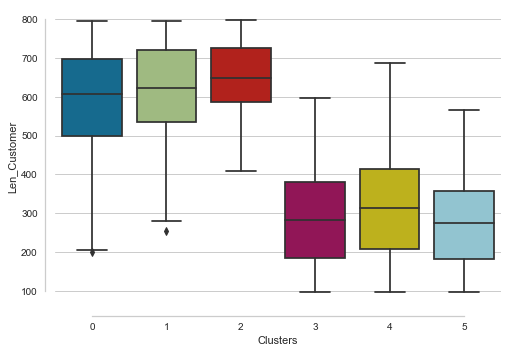

In [38]:
sns.boxplot(x="Clusters", y="Len_Customer",
            #hue="AcceptedCmpTot", palette=["m", "g","y","b","p"],
            data=df)
sns.despine(offset=10, trim=True)

In [39]:
### Compared to Cluster 1, Cluster 3 have been with the comapany much longer.  However, Cluster 1 has been with the company even longer and Cluster 5 has been with the company a long time as well.

In [40]:
### As seen below, if we normalize by length spent as customer, Cluster 1 spends the most in every category

In [41]:
df['MntWinesNorm']=df['MntWines']/df['Len_Customer']

df['MntFruitsNorm']=df['MntFruits']/df['Len_Customer']

df['MntMeatProductsNorm']=df['MntMeatProducts']/df['Len_Customer']

df['MntFishProductsNorm']=df['MntFishProducts']/df['Len_Customer']

df['MntSweetProductsNorm']=df['MntSweetProducts']/df['Len_Customer']

df['MntGoldProdsNorm']=df['MntGoldProds']/df['Len_Customer']

df['NumDealsPurchasesNorm']=df['NumDealsPurchases']/df['Len_Customer']

df['NumWebPurchasesNorm']=df['NumWebPurchases']/df['Len_Customer']

df['NumStorePurchasesNorm']=df['NumStorePurchases']/df['Len_Customer']

df['NumWebVisitsMonthNorm']=df['NumWebVisitsMonth']/df['Len_Customer']

df['NumCatalogPurchasesNorm']=df['NumCatalogPurchases']/df['Len_Customer']

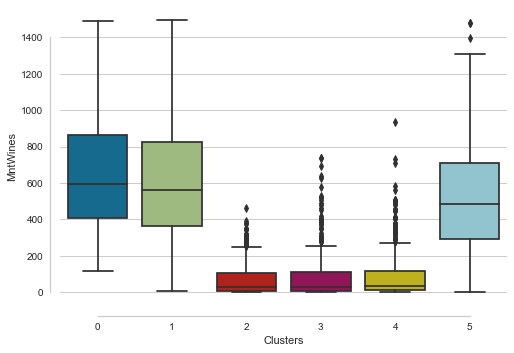

In [42]:
sns.boxplot(x="Clusters", y="MntWines",
            data=df)
sns.despine(offset=10, trim=True)

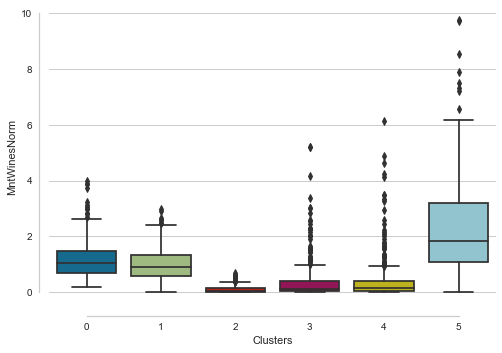

In [43]:
sns.boxplot(x="Clusters", y="MntWinesNorm",
            data=df)
sns.despine(offset=10, trim=True)

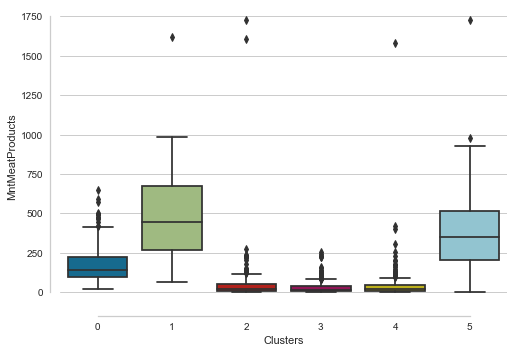

In [44]:
sns.boxplot(x="Clusters", y="MntMeatProducts",
            data=df)
sns.despine(offset=10, trim=True)

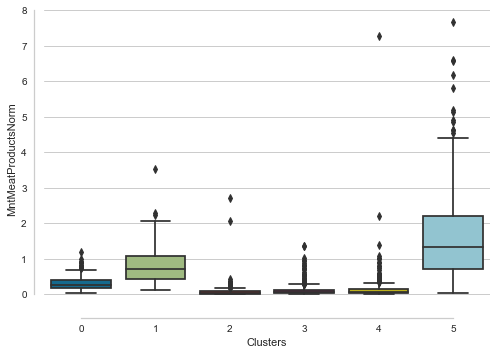

In [45]:
sns.boxplot(x="Clusters", y="MntMeatProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

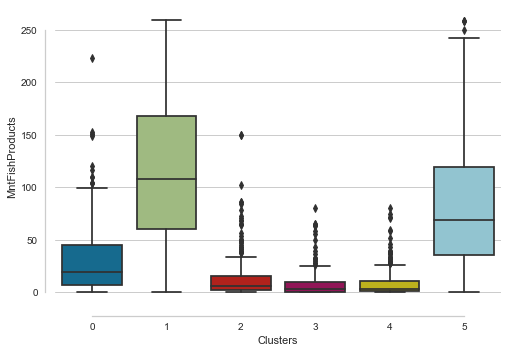

In [46]:
sns.boxplot(x="Clusters", y="MntFishProducts",
            data=df)
sns.despine(offset=10, trim=True)

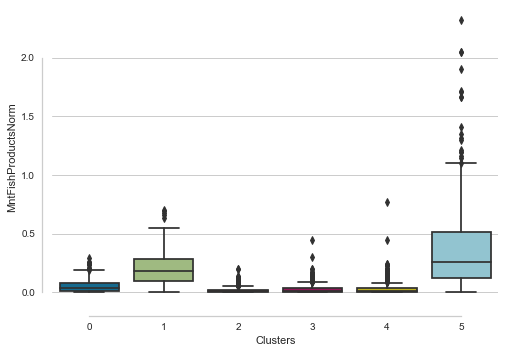

In [47]:
sns.boxplot(x="Clusters", y="MntFishProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

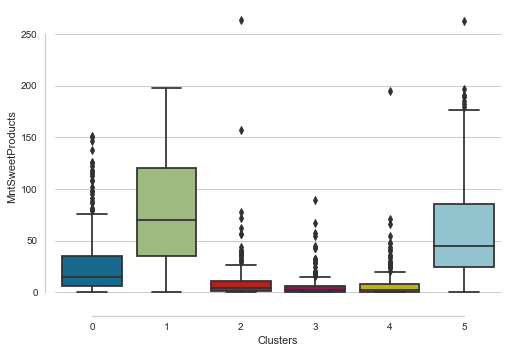

In [48]:
sns.boxplot(x="Clusters", y="MntSweetProducts",
            data=df)
sns.despine(offset=10, trim=True)

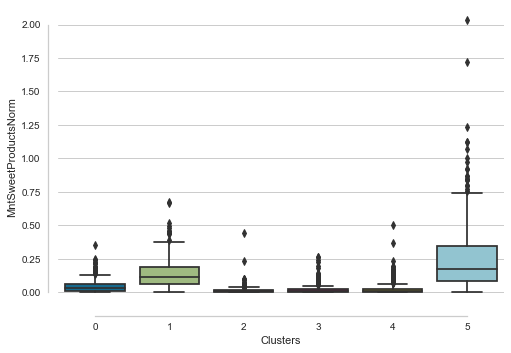

In [49]:
sns.boxplot(x="Clusters", y="MntSweetProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

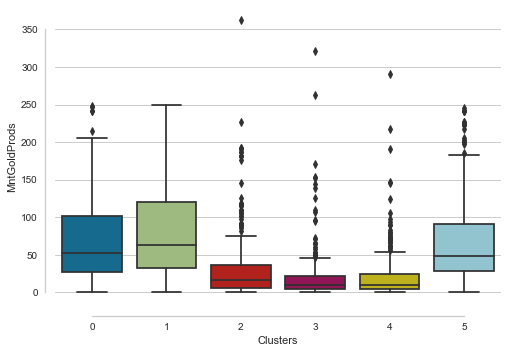

In [50]:
sns.boxplot(x="Clusters", y="MntGoldProds",
            data=df)
sns.despine(offset=10, trim=True)

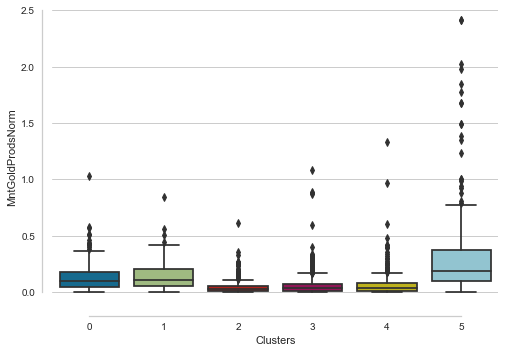

In [51]:
sns.boxplot(x="Clusters", y="MntGoldProdsNorm",
            data=df)
sns.despine(offset=10, trim=True)

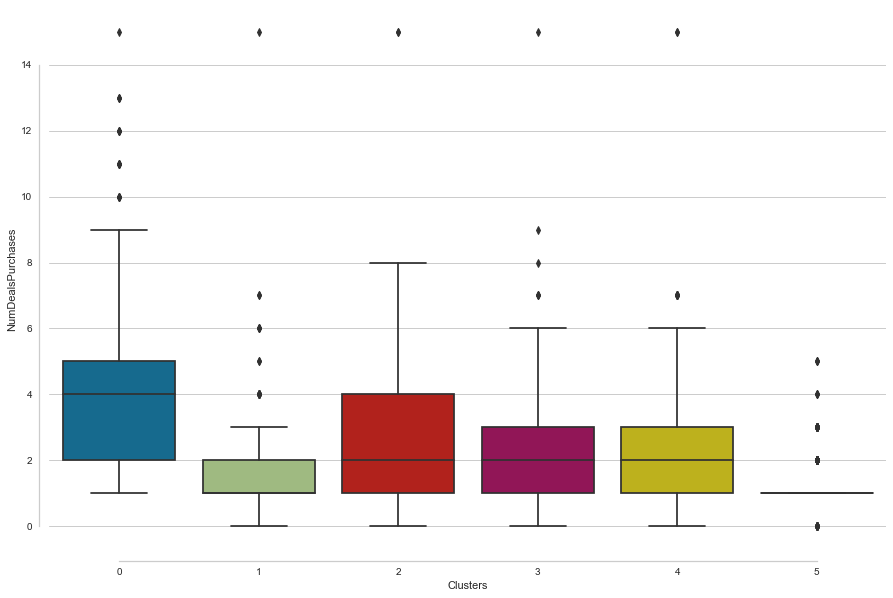

In [53]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="NumDealsPurchases",
            data=df)
sns.despine(offset=10, trim=True)

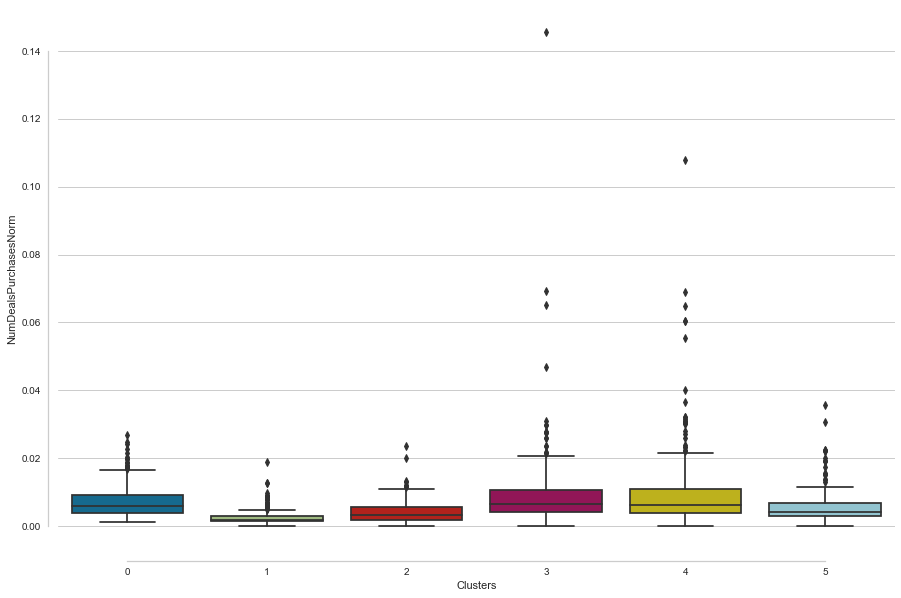

In [54]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="NumDealsPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

In [55]:
### Clusters 1 and 3 rarely go for deal purchases compared to Cluster 5, for example.  Cluster 5 customers are much more likely to have at least one child than clusters 1 and 3.  

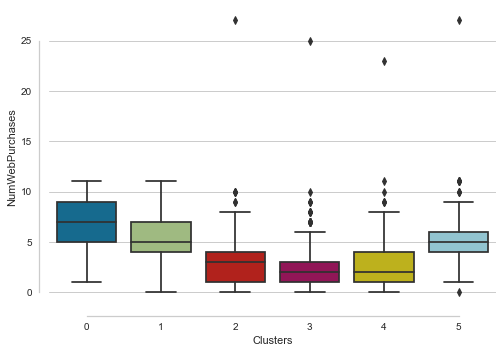

In [56]:
sns.boxplot(x="Clusters", y="NumWebPurchases",
            data=df)
sns.despine(offset=10, trim=True)

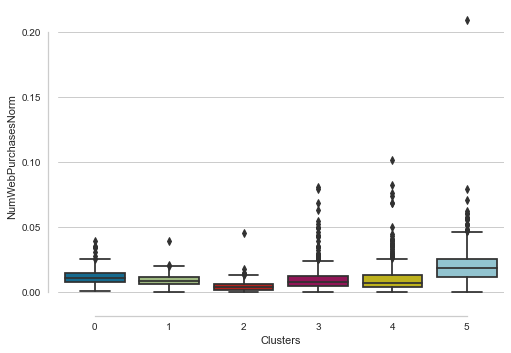

In [57]:
sns.boxplot(x="Clusters", y="NumWebPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

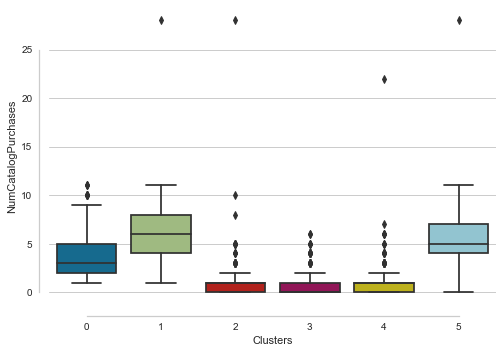

In [58]:
sns.boxplot(x="Clusters", y="NumCatalogPurchases",
            data=df)
sns.despine(offset=10, trim=True)

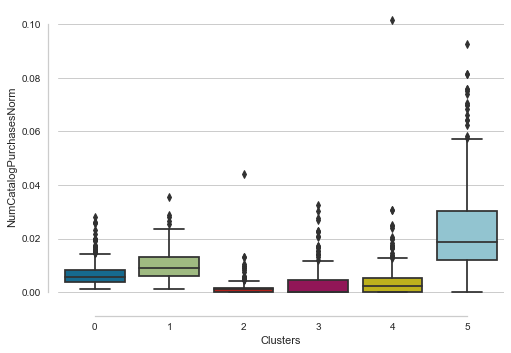

In [59]:
sns.boxplot(x="Clusters", y="NumCatalogPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

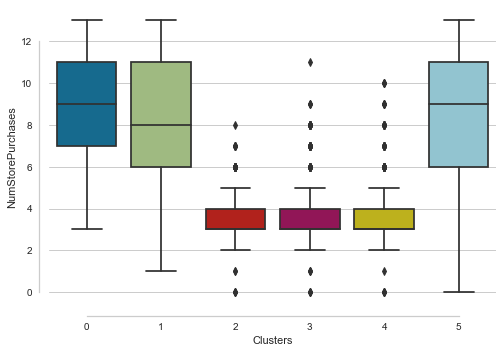

In [60]:
sns.boxplot(x="Clusters", y="NumStorePurchases",
            data=df)
sns.despine(offset=10, trim=True)

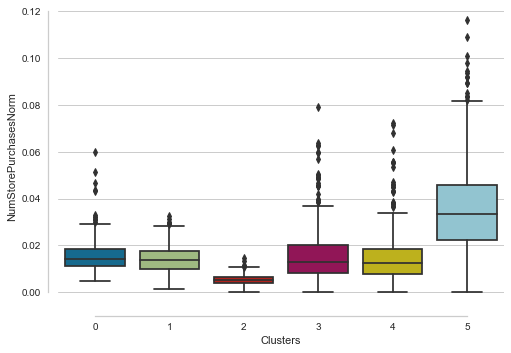

In [61]:
sns.boxplot(x="Clusters", y="NumStorePurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

In [62]:
# When normalized, Cluster 1 makes the most web, catalog and in-store puchases.  
# Cluster 3 relatively prone to catalog purchases
# Cluster 5 relatively prone to web purchases

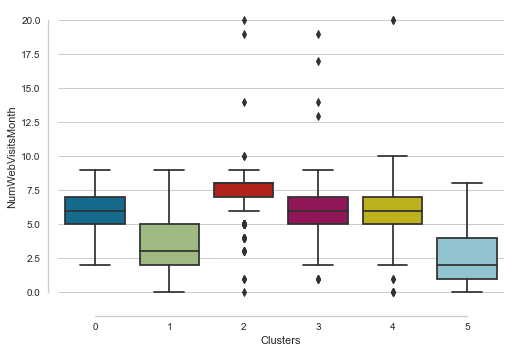

In [63]:
sns.boxplot(x="Clusters", y="NumWebVisitsMonth",
            data=df)
sns.despine(offset=10, trim=True)

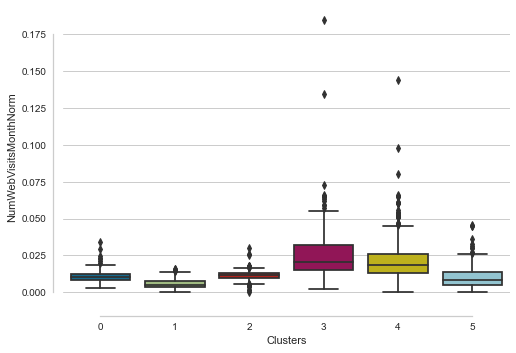

In [64]:
sns.boxplot(x="Clusters", y="NumWebVisitsMonthNorm",
            data=df)
sns.despine(offset=10, trim=True)

In [65]:
# Cluster 2 visit the web the most.  Cluster 4 is also active on the web.  Target a campaign for them there by giving them targeted deals!

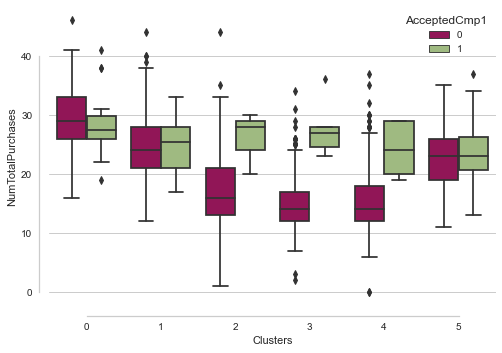

In [140]:
sns.boxplot(x="Clusters", y="NumTotalPurchases",
            hue="AcceptedCmp1", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

In [66]:
### Although 1 spend less than 3 total, their spending normalized by length as customers is much higher!
### Focus on attracting this recent revenue-bringing group

<AxesSubplot:xlabel='Clusters', ylabel='MntSpentNorm'>

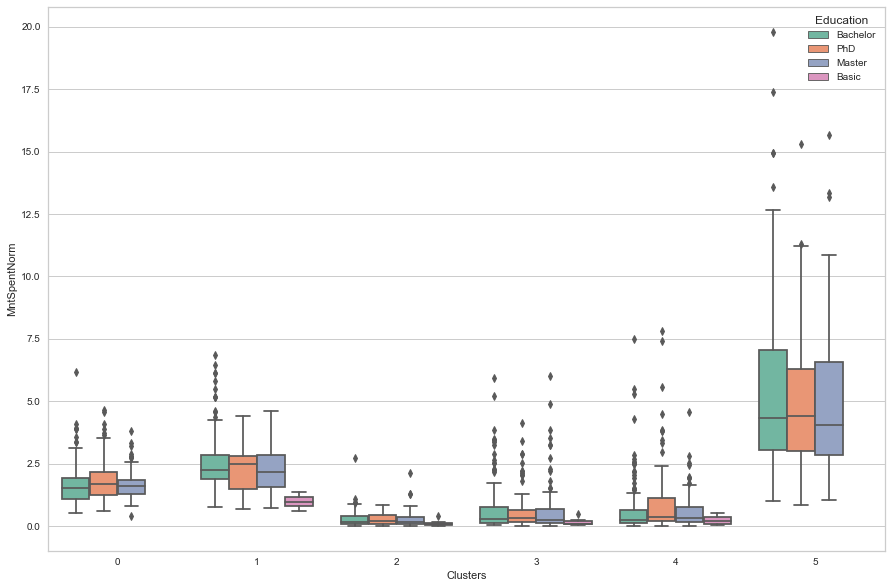

In [141]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="Education", palette=palette,
            data=df)
#sns.despine(offset=10, trim=True)

### Overall, higher-educated customers spend more

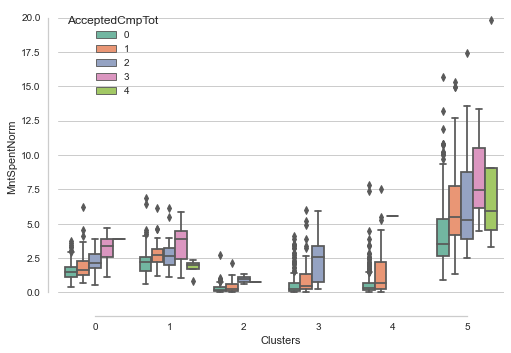

In [142]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

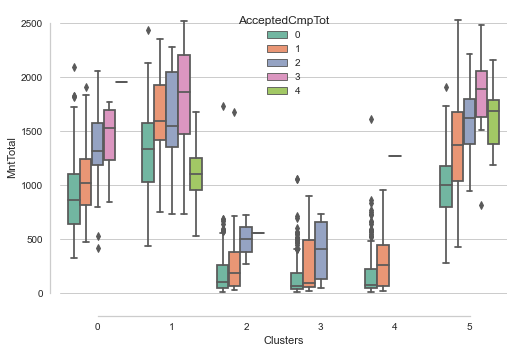

In [143]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

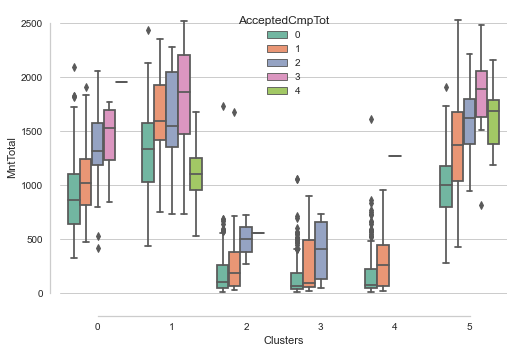

In [144]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

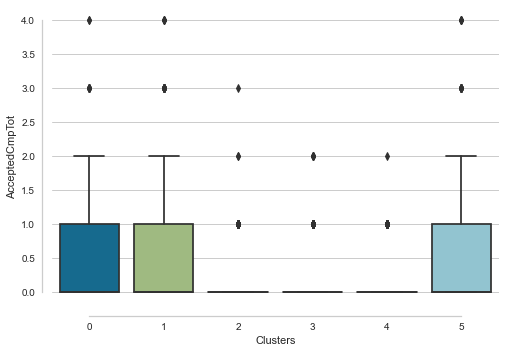

In [77]:
sns.boxplot(x="Clusters", y="AcceptedCmpTot",
            #hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

### What about the amounts spent on other goods when normalized?

In [146]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters', 'MntWinesNorm', 'MntFruitsNorm',
       'MntMeatProductsNorm', 'MntFishProductsNorm', 'MntSweetProductsNorm',
       'MntGoldProdsNorm', 'NumDealsPurchasesNorm', 'NumWebPurchasesNorm',
       'NumStorePurchasesNorm', 'NumWebVisitsMonthNorm',
       'NumCatalogPurchasesNorm'],
      dtype='object')

In [147]:
# df['AcceptedCmpTotNorm']=df['AcceptedCmpTot']/df['Len_Customer'] Don't do that!


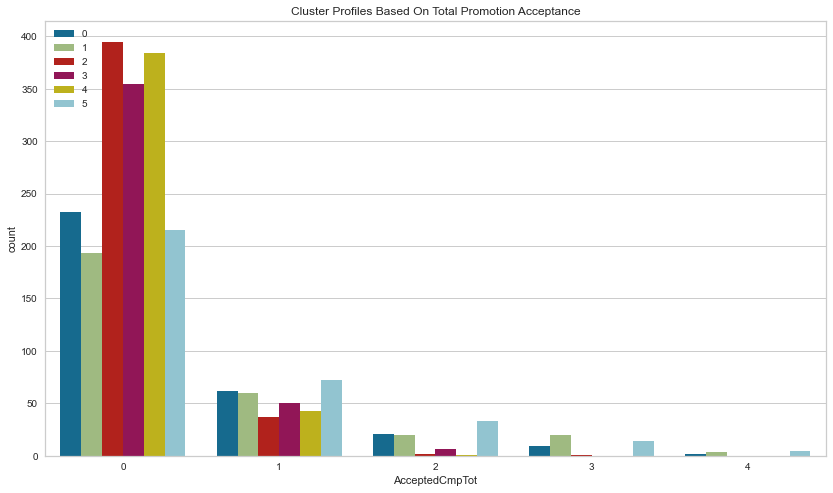

In [78]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmpTot"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Total Promotion Acceptance")
plt.legend()
plt.show()

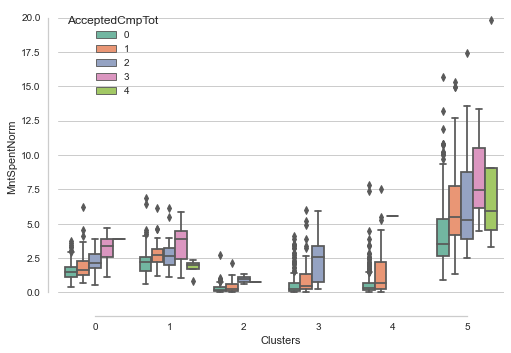

In [150]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

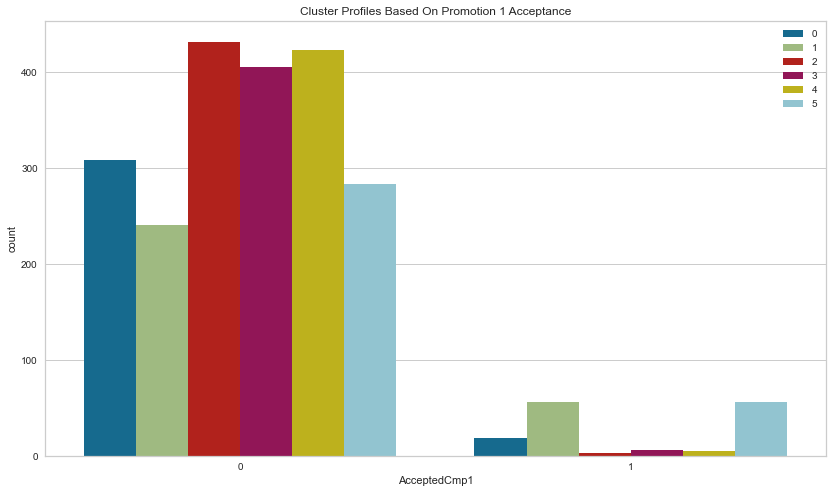

In [151]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp1"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 1 Acceptance")
plt.legend()
plt.show()

In [ ]:
### Cluster 3 responded to campaign 1

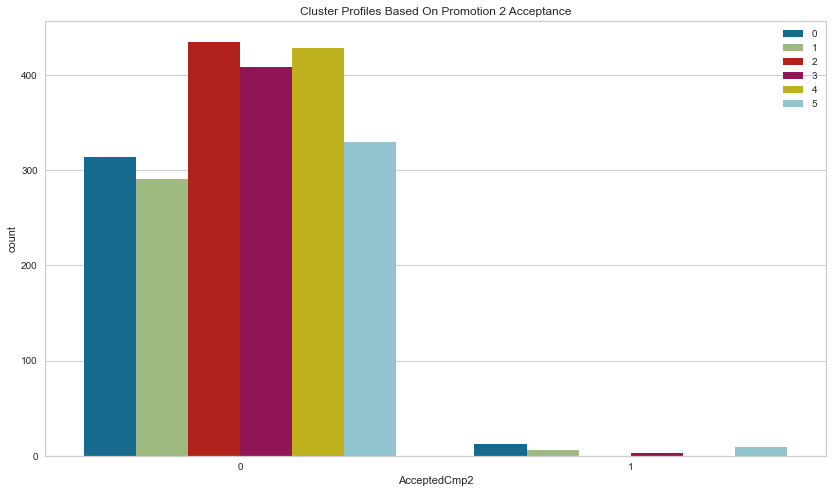

In [152]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp2"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 2 Acceptance")
plt.legend()
plt.show()

In [ ]:
### Campaign 2 was unsuccessful base on response rate

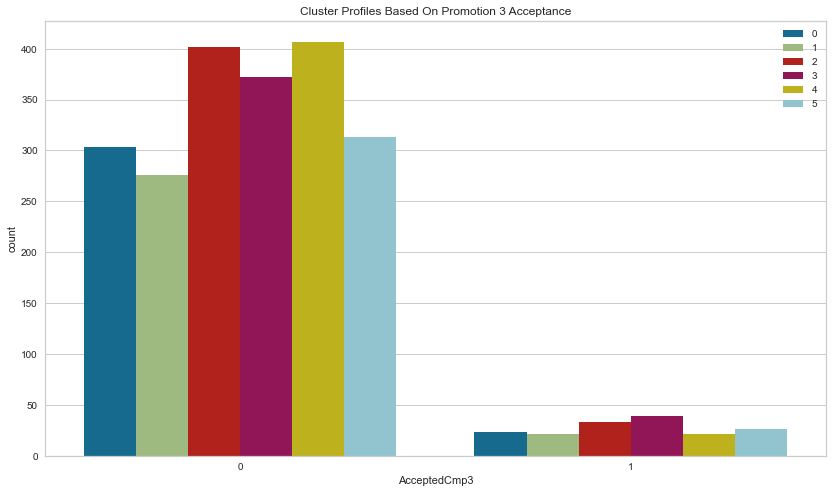

In [153]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp3"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 3 Acceptance")
plt.legend()
plt.show()

In [ ]:
### Cluster 2 was particularly prone to accept campaign 3

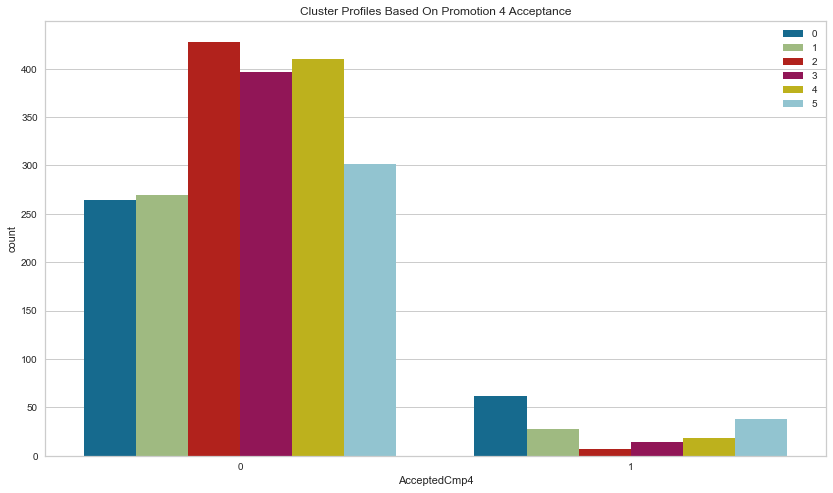

In [154]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp4"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 4 Acceptance")
plt.legend()
plt.show()

In [ ]:
### Cluster 2 was particularly prone to accept campaign 4

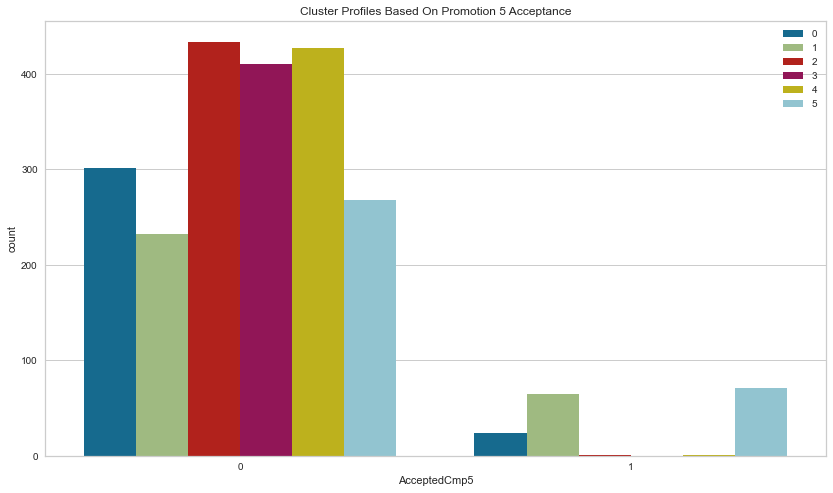

In [155]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp5"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 5 Acceptance")
plt.legend()
plt.show()

In [ ]:
### Clusters 1 and 3 was particularly prone to accept campaign 5

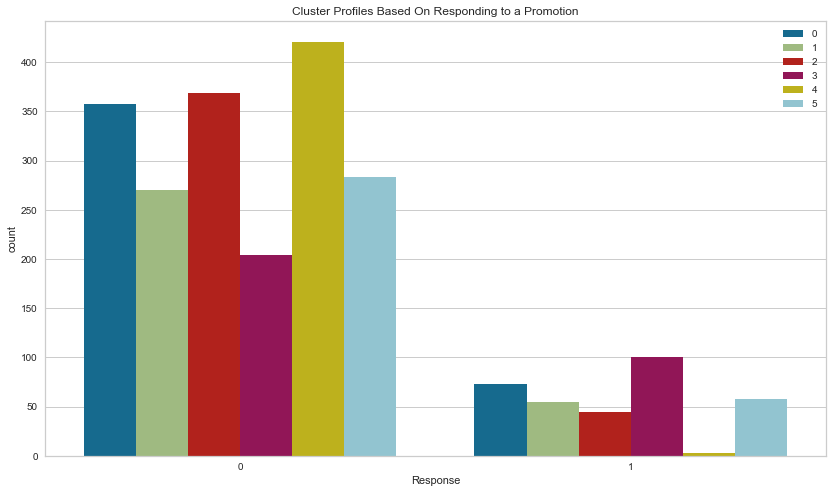

In [71]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Response"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Responding to a Promotion")
plt.legend()
plt.show()

### Not sure if 'Response' is particularly meaningful

## Analysis before dropping the age outliers

### Cluster 4 is the most responsive to promotions.  Who are these customers?
- Upper middle class
- College educated or above, with a heavy represenation of people with PhDs
- Mostly married or living together
- Are less likely to have children than average, and have fewer children
- Story: Highly educated professors and professionals -> The "Strivers"
- We don't know much about these promotions, but perhaps they are for wines, meats, and more expensive items

### Cluster 1 are the repeated deal hunters.  Who are they?
- Higher than average income (.5 standard dev)
- Highly educated (lots of PhDs)
- Overwhelmingly have children
- The 'Familied Philosophers'

In [ ]:
<!-- # Description of Customer Characteristics
- Cluster 0: Lowest median income of all clusters (1 std to the left). The biggest cluster.
- Cluster 1: High median income (1 std to the right)
- Cluster 2: Lower than average median income (1 std to the left)
- Cluster 3: Lower than average median income (.5 std to the left)
- Cluster 4: Lower than average median income (.5 std to the left)
- Cluster 5: Highish median income (.5 std to the right)
- All clusters similar in age, with Cluster 0 slightly younger  -->

#### Recommend A/B testing on clusters